# Example notebook exploring CPTAC protein abundances
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/isb-cgc/Community-Notebooks/blob/Staging-Notebooks/Staging-Notebooks/Clustergram_CCRCC.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
</table>


Check out more notebooks at our [Community Notebooks Repository!](https://github.com/isb-cgc/Community-Notebooks)

```
Title:   Clustergram CCRCC
Author:  Boris Aguilar
Created: 01-19-20
Purpose: Retrive and analyze protein abundances from CPTA
Notes:   This notebook recapitulates the following notebook https://pdc.cancer.gov/API_documentation/PDC_clustergram.html 
```
The notebook extracts protein abundances from the CPTAC Clear cell renal cell carcinoma (CCRCC) quant and their associated clinical metadata from the publicly available BigQuery tables that the ISB-CGC project has produced based on CPTAC. 
Finally the notebooks cluster and visualize the data using the Seaborn clustermap package.


## Modules

In [ ]:
from google.cloud import bigquery
from google.colab import auth
import seaborn as se
import pandas as pd
import pandas_gbq
import matplotlib.pyplot as plt

## Defining helper functions

In [ ]:
# A color mapping function for the clinical annotations
def get_colors(df, name, color) -> pd.Series:
    s = pd.Series( df[name] ) 
    su = s.unique()
    colors = se.light_palette(color, len(su))
    lut = dict(zip(su, colors))
    return s.map(lut)

## Google Authentication
The first step is to authorize access to BigQuery and the Google Cloud. For more information see ['Quick Start Guide to ISB-CGC'](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/HowToGetStartedonISB-CGC.html) and alternative authentication methods can be found [here](https://googleapis.dev/python/google-api-core/latest/auth.html).

Moreover you need to [create a google cloud](https://cloud.google.com/resource-manager/docs/creating-managing-projects#console) project to be able to run BigQuery queries.

In [ ]:
auth.authenticate_user()
my_project_id = "" # write your project id here

## Fetch the data
The following code obtains protein abundances and clinical metada for the all the cases in the CPTAC CCRCC study. Specifically we join two tables quant_proteome_CPTAC_CCRCC_discovery_study_pdc_current and clinical_CPTAC3_discovery_pdc_current that host protein abundances and clinical metada, respectively. 

The results of query is automatically stored in pandas dataframe (quant_data) by the function read_gbq. 

In [ ]:
sql = '''
SELECT pg.aliquot_submitter_id, pg.gene_symbol, 
       pg.protein_abundance_log2ratio as log2ratio,
       clin.tumor_stage, clin.primary_diagnosis 
FROM `isb-cgc-bq.CPTAC.quant_proteome_CPTAC_CCRCC_discovery_study_pdc_current` as pg
JOIN `isb-cgc-bq.CPTAC.clinical_CPTAC3_discovery_pdc_current` as clin
ON pg.case_id = clin.case_id
'''
quant_data = pandas_gbq.read_gbq(sql,project_id=my_project_id )
quant_data


Downloading: 100%|██████████| 1985337/1985337 [01:21<00:00, 24388.03rows/s]


,aliquot_submitter_id,gene_symbol,log2ratio,tumor_stage,primary_diagnosis
0,CPT0012920003,COX1,-0.8502,Stage I,"Renal cell carcinoma, NOS"
1,CPT0086030003,COX1,-2.2002,Stage I,"Renal cell carcinoma, NOS"
2,CPT0063320003,COX1,-0.2709,Stage I,"Renal cell carcinoma, NOS"
3,CPT0092290003,COX1,-0.3957,Stage I,"Renal cell carcinoma, NOS"
4,CPT0023690003,COX1,-1.1156,Stage I,"Renal cell carcinoma, NOS"
...,...,...,...,...,...
1985332,QC5,WAC,-0.2038,Not Reported,Not Reported
1985333,NCI7-4,WAC,0.7020,Not Reported,Not Reported
1985334,NCI7-2,LZTR1,0.0691,Not Reported,Not Reported
1985335,NCI7-4,LZTR1,0.4710,Not Reported,Not Reported


## Analysis
The clustermap module within the Seaborn package does not allow for NaN values. So we must create a mask value that does not interfere much with the clustering and is likely to be unique.

In [ ]:
mask_na = 0.000666
quant_data = quant_data.fillna(mask_na)

We then need pivot the data.

In [ ]:
ga = pd.pivot_table(quant_data,values='log2ratio', 
                               index='gene_symbol', 
                               columns='aliquot_submitter_id')
print(ga.shape)

(9591, 207)


Next we set up colors for the clinical features *tumor_stage* and *primary_diagnosis*

In [ ]:
labels = quant_data[['aliquot_submitter_id','tumor_stage','primary_diagnosis']].drop_duplicates().set_index('aliquot_submitter_id')
stage_col_colors = get_colors(labels, 'tumor_stage', 'red')
diagnosis_col_colors = get_colors(labels, 'primary_diagnosis', 'green')

Finally we generate clustergram

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


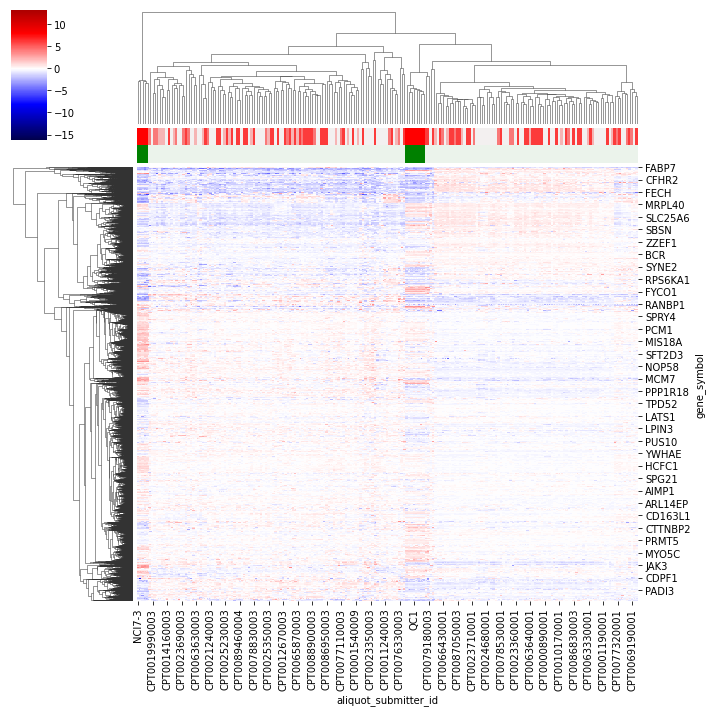

In [ ]:
se.clustermap(ga, metric='euclidean', method='complete', cmap='seismic', mask=ga == 0.000666, center=0.,
              figsize=(10, 10), col_colors= [ stage_col_colors, diagnosis_col_colors] )
plt.show() #12.5 50